# Лабораторная работа 4 

# Мультиязычный тематический поиск


### Бобряков А.С.

## Введение

### Постановка задачи:

В этом задании вам предстоит сделать свою небольшую мультиязычную поисковую систему. Проще всего строить мультиязычные системы, имея "параллельные" данные: словари или корпуса параллельных текстов. 

В задании необходимо, имея англо-русскую и агло-испанскую коллекции, обучить модель поиска модель поиска испанских текстов по русским.

Решение этого задания будет основано на тематическом моделировании, а именно подходе аддитивной регуляризации.

### Библиотеки

Для этого задания вам понадобятся следующие библиотеки:
 - [bigartm](http://bigartm.org/)
 - [pymorphy2](https://pymorphy2.readthedocs.io/en/latest/)
 - [nltk](http://www.nltk.org/)


### Данные

Данные — записи выступлений конференции TED Talks на трёх языках. 

Все данные содержатся в архиве `ted_collection`. В папке содержится три подпапки `/en`, `/ru` и `/es`, каждая из которых соответствует коллекции для отдельного языка. Папка `parallel_info`  содержит информацию о связях документов между коллекциями. Файл `titles_file.json` содержит информацию о заголовках документов английской коллекции.

Ссылка для скачивания данных: [ссылка на гугл диск](https://drive.google.com/file/d/1B3kDfISvWnVpEet_CDa6oLNp028mEak-/view)

#### Импорт важных библиотек

In [6]:
# считывание
import os
import glob
import json

# предобработка
import pymorphy2
import nltk
import re

# тематическое моделирование
import artm

# change log style for artm
lc = artm.messages.ConfigureLoggingArgs()
lc.minloglevel = 3
lib = artm.wrapper.LibArtm(logging_config=lc)

# визуализация
import matplotlib.pyplot as plt
%matplotlib inline

# прочее 
import numpy as np

#### Несколько важных промежуточных функций

In [7]:
# загрузка коллекции
from lab4_utils import load_collection

# загрузка информации о параллельных документах
from lab4_utils import load_parallel_documents_info

# запись vowpal wabit файла специального формата
from lab4_utils import write_vw_lab4

# подсчёт позиции в выдаче переводов текстов
from lab4_utils import get_indexes_of_relevant_documents

## Предобработка данных (3 балла)

Перед тем как начать моделировать, необходимо предобработать данные. 

Заметим, что для английского языка некоторые этапы обработки не оказывают сильного влияния на модель (например, лемматизация). В русском языке одному слову может соответствовать огромное количество различных форм, поэтому без лемматизации невозможно получить модель с хорошим качеством.

#### Предобработка русских текстов


Считываем коллекцию:

In [23]:
RU_DATA_PATH = 'ted_collection/ru'
ru_collection = load_collection(RU_DATA_PATH, verbose=True)

Total number of documents: 2731

Some document examples: 
	Сегодня я бы хотел поговорить о перспективной области науки, области спорной, но чрезвычайно интерес...
	Так начинается война: вы живёте обычной жизнью, собираетесь пойти в гости, отводите детей в школу, з...
	Я опубликовала эту статью в колонке «Современная любовь» газеты «Нью-Йорк Таймс» в январе этого года...
	Вплоть до недавнего времени общение человека с машиной ограничивалось сознательными и непосредственн...
	Я пережила особое удовольствие жизни внутри двух биосфер. Конечно, все мы тут в этом зале живём в Би...

Some file names examples: 
	ru_2291
	ru_1320
	ru_944
	ru_2648
	ru_1393


Выведите полностью несколько документов. Подумайте, какую информацию из них можно удалить на этапе предобработки, не ухудшив качество решения задачи.

In [44]:
# Из конца всех документов можно удалить 
#'TED.com translations are made possible by volunteer translators.
# Learn more about the Open Translation Project.\n© TED Conferences, LLC. All rights reserved.'

num_del = 0
s = '\nTED.com translations are made possible by volunteer translators. Learn more about the Open Translation Project.\n© TED Conferences, LLC. All rights reserved.'
for key, doc in ru_collection.items():
    if doc[-len(s):] == s:
        ru_collection[key] = doc[:-len(s)]
        num_del += 1
print(f'Удалено {num_del} окончаний в {len(ru_collection)} документах.')

Удалено 2731 окончаний в 2731 документах.


Помимо удаления специфичной информации, вам необходимо провести для русского языка следующие шаги предобработки :

1. Приведение документов к нижнему регистру.

2. Удаление всех символов кроме букв.
    1. Для некоторых способов выделения коллокаций (см. бонусную часть), может быть полезна информация о знаках препинания. Также она полезна при необходимости строить синтаксический разбор предложения.
    2. Вам может помочь функция sub из библиотеки re.
3. Токенизация документов.
    1. Воспользуйтесь стандартным методом .split, функцией split из библиотеки re или одним из токенайзеров библиотеки nltk.
4. Лемматизация документов.
    1. Воспользуйтесь библиотекой pymorphy2
    2. Шаги 3 и 4 можно выполнить вместе, воспользовавшись библиотекой mytem (или её обёрткой на python pymystem)
5. Удаление стоп-слов
    1. Базовый список стоп слов можно получить из модуля nltk.corpus

После выполнения всех шагов сохраните результат в словарь аналогичный ru_collection (ключи - названия файлов, значения - предобработанный документ в формате str).



In [48]:
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
import string

morph = pymorphy2.MorphAnalyzer()

def ru_text_prepare(text):
    """
        text: a string
        
        return: modified string
    """
    for i in string.punctuation:
        text = text.replace(i, ' ')
    text = re.sub(r'[^\w ]+', '', text.lower())
    words = text.split()
    sw = set(stopwords.words('russian'))
    return ' '.join([morph.parse(i)[0].normal_form for i in words if i not in sw])

for key, doc in tqdm(ru_collection.items()):
    ru_collection[key] = ru_text_prepare(doc)

/home/nick/snap/jupyter/common/lib/python3.7/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)


Проанализируйте несколько предобработанных документов. Отметьте, какие неточности работы алгоритмов вы заметили, и как они могут повлиять на итоговую модель.

In [49]:
ru_collection['ru_2291']

'сегодня хотеть поговорить перспективный область наука область спорный чрезвычайно интересный безусловно стремительно развивающийся квантовый биология пытаться ответить вопрос мочь закон квантовый механика удивительный теория поведение субатомный частица атом молекула лежать основа многий направление современный физика химия действовать также внутри живой клетка говорить иначе происходить живой организм явление который объяснить помощь квантовый механика итак квантовый биология новый направление возникнуть начало 30 х лишь недавно ход эксперимент применение спектроскопия доказать некоторый явление объясняться помощь квантовый механика квантовый биология интересовать квантовый физик биохимик молекулярный биолог область объединять дисциплина заниматься квантовый физика физик ядерщик потребоваться 30 год освоить принцип квантовый механика основатель квантовый механика нильс бор сказать потрясти её ещё понять рад сей пора восхищать это здорово исследовать мелкий частица вселенная кирпичик 

#### Предобработка английских текстов

Считываем коллекцию:

In [58]:
EN_DATA_PATH = 'ted_collection/en'
en_collection = load_collection(EN_DATA_PATH, verbose=True)

Total number of documents: 2856

Some document examples: 
	I am holding something remarkably old. It is older than any human artifact, older than life on Earth...
	I have spent the past 38 years trying to be invisible. I'm a copy editor. I work at The New Yorker, ...
	Once upon a time, the world was a big, dysfunctional family. It was run by the great and powerful pa...
	What I want to talk about today is one idea. It's an idea for a new kind of school, which turns on i...
	The big residual is always value for money. All the time we are trying to get value for money. What ...

Some file names examples: 
	en_1874
	en_59
	en_732
	en_2054
	en_2591


Проведите все этапы предобработки для английского языка (шаг 4 опционален, можно использовать WordNetLemmatizer из nltk):

In [59]:
num_del = 0
s = '\nTED.com translations are made possible by volunteer translators. Learn more about the Open Translation Project.\n© TED Conferences, LLC. All rights reserved.'
for key, doc in en_collection.items():
    if doc[-len(s):] == s:
        en_collection[key] = doc[:-len(s)]
        num_del += 1
print(f'Удалено {num_del} окончаний в {len(en_collection)} документах.')

Удалено 2856 окончаний в 2856 документах.


In [60]:
from nltk import WordNetLemmatizer

wnl = WordNetLemmatizer()

def en_text_prepare(text):
    """
        text: a string
        
        return: modified string
    """
    for i in string.punctuation:
        text = text.replace(i, ' ')
    text = re.sub(r'[^\w ]+', '', text.lower())
    words = text.split()
    sw = set(stopwords.words('english'))
    return ' '.join([wnl.lemmatize(i) for i in words if i not in sw])

for key, doc in tqdm(en_collection.items()):
    en_collection[key] = en_text_prepare(doc)

In [61]:
en_collection['en_0']

'know continually amazed think two half billion u around world connected internet point time 30 percent world population go online learn create share amount time u spending also continuing go grow recent study showed young generation alone spending eight hour day online parent nine year old girl number seems awfully low laughter internet opened world every one u also opened every one u world increasingly price asked pay connectedness privacy today many u would love believe internet private place every click mouse every touch screen like hansel gretel leaving breadcrumb personal information everywhere travel digital wood leaving birthday place residence interest preference relationship financial history go get wrong one minute suggesting sharing data bad thing fact know data shared asked explicitly consent want site understand habit help suggest book read movie family watch friend u connect know asked problem arises phenomenon internet today called behavioral tracking big business fact 

#### Предобработка испанских текстов 

Считываем коллекцию:

In [62]:
ES_DATA_PATH = 'ted_collection/es'
es_collection = load_collection(ES_DATA_PATH, verbose=True)

Total number of documents: 2809

Some document examples: 
	He estado trabajando en el tema de la pobreza por más de 20 años, y es irónico que el problema y la ...
	Sin duda vivimos en un momento de crisis Es posible que los mercados financieros nos hayan fallado y...
	Entonces ¿qué tiene que ver esta imagen con esto? Y tengo que decir, creo que Emeka está intentando ...
	Quiero hablarles hoy de un tema difícil, que me es cercano y quizás más cercano a sus vidas de lo qu...
	He pasado mi vida entera ya sea en la escuela, en el camino a la escuela o, hablando de lo que pasa ...

Some file names examples: 
	es_1940
	es_1279
	es_1519
	es_2515
	es_1181


Проведите все этапы предобработки для испанского языка (шаг 4 опционален, можно использовать SpanishStemmer из nltk). 

**Замечание.** Регулярное выражение \w из библиотеки re позволяет выделять буквы (в том числе буквы испанского алфавита).

In [63]:
num_del = 0
s = '\nTED.com translations are made possible by volunteer translators. Learn more about the Open Translation Project.\n© TED Conferences, LLC. All rights reserved.'
for key, doc in es_collection.items():
    if doc[-len(s):] == s:
        es_collection[key] = doc[:-len(s)]
        num_del += 1
print(f'Удалено {num_del} окончаний в {len(es_collection)} документах.')

Удалено 2809 окончаний в 2809 документах.


In [70]:
from nltk.stem.snowball import SpanishStemmer

ss = SpanishStemmer()

def es_text_prepare(text):
    """
        text: a string
        
        return: modified string
    """
    for i in string.punctuation:
        text = text.replace(i, ' ')
    text = re.sub(r'[^\w ]+', '', text.lower())
    words = text.split()
    sw = set(stopwords.words('spanish'))
    return ' '.join([ss.stem(i) for i in words if i not in sw])

for key, doc in tqdm(es_collection.items()):
    es_collection[key] = es_text_prepare(doc)

In [71]:
es_collection['es_0']

'se siempr asombr pens 2 000 millon medi mund interconect traves internet cualqui moment 30 poblacion mundial pued line aprend cre compart tiemp cad pas hac cos continu crec estudi recient demostr sol gener jov pas 8 hor dia line padr niñ 9 años cifr parec baj ris asi internet abiert mund muestr mund cad vez preci deb pag hech conect privac hoy dia gust cre internet lug priv cad clic cad toqu pantall hansel gretel dej mig pan inform personal siti visit bosqu digital dej cumpleañ direccion interes preferent relacion histori financ asi suces malinterpret sugir intercambi dat mal hech se cual dat compart doy consent explicit interes siti conozc habit ayud suger libr pelicul ver famili amig quien conect problem surg se ped permis fenomen internet hoy llam seguimient comport gran negoci hech tod industri form torn segu traves bosqu digital compil perfil cad recopil dat pued hac casi quier trat are hoy dia poc regul much men norm excepcion anunci recient aqu unid europ are proteccion consumi

Из неточностей алгоритма могу отметить то, что некоторые слова лемматизируются неверно, например слово 'us' превращается в 'u'. Кроме того, некоторые выражения заведомо обрабатываются неверно, чем мы принебрегаем, например выражение 'в 80-х' превращается в '80 x'.

#### Дополнительная предобработка

Библиотека BigARTM имеет собственный формат документов для обработки, называемый батчами. Самый простой способ создать батчи из коллекции файлов - сконвертировать в батчи vowpal wabbit файл с коллекцией (https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Input-format). 

Тематические модели работают с мешком слов, поэтому в vowpal wabbit файле можно не хранить информацию о порядке слов в документе.

Чтобы обучить мультиязычную модель, мы будем использовать апарат модальностей тематической модели. Каждому языку будет соответствовать своя модальность (`@english`, `@russian` и `@spanish` в vowpal wabbit файле). 

Для экспериментов нам понадобится два файла. Один будет содержать информацию о параллельных документов, а другой нет. В втором файле каждая строчка соответствует конкретному документу. В первом файле, если у документа есть параллельный, он будет располагаться на этой же строчке в рамках другой модальности.

Весь код для сохранения файла в vowpal wabbit формате уже написан, вам только необходимо правильно воспользоваться функцией. В частности, проследите, чтобы в ваших документах не содержалось символов ':', '|' и '@'.

В файлах en_ru_match.txt и en_es_match.txt содержится информация о том, какие документы являются параллельными. 

In [73]:
en_ru_parallel_docs = load_parallel_documents_info('ted_collection/en_ru_match.txt')
en_es_parallel_docs = load_parallel_documents_info('ted_collection/en_es_match.txt')

Total number of pairs: 1000
Total number of pairs: 1000


Воспользуйтесь функцией write_vw_lab4, чтобы сохранить данные в нужном формате:

In [74]:
# vowpal wabbit файлы с коллекцией
DATA_PATH_PARALLEL = 'ted_collection/collection_parallel.vw'
DATA_PATH_MONO = 'ted_collection/collection_mono.vw'

write_vw_lab4(
    DATA_PATH_PARALLEL,
    en_collection,
    ru_collection,
    es_collection,
    en_ru_parallel_docs,
    en_es_parallel_docs,
    use_parallel_info=True
)


write_vw_lab4(
    DATA_PATH_MONO,
    en_collection,
    ru_collection,
    es_collection,
    en_ru_parallel_docs,
    en_es_parallel_docs,
    use_parallel_info=False
)

## Базовая моноязычная тематическая модель (2 балла)

Теорию тематического моделирования можно узнать из соответствующей лекции курса.

Научиться пользоваться bigartm легче всего по гайду из документации [ссылка](http://docs.bigartm.org/en/stable/tutorials/python_userguide/index.html).

#### Подготовка к моделированию

Чтобы преобразовать полученный vowpal wabbit файл в батчи, можно воспользоваться стандартным классом BatchVectorizer. Объект этого класса принимает на вход адрес папки с батчами или файл vowpal wabbit, а затем подаётся на вход для обучения методам. В случае, если входные данные не являются батчами, он создаёт их и сохраняет на диск для последующего быстрого использования.

В этой части экспериментов, вам предлагается построить моноязычную тематическую модель только для английского языка, поэтому для обучения используйте файл DATA_PATH_MONO.

In [86]:
# папка с батчами
BATCHES_PATH_MONO = 'ted_collection/batches_mono'

In [87]:
# если BATCHES_PATH_MONO пуста, батчи будут созданы из файла в DATA_PATH_MONO
# иначе использовать BATCHES_PATH_MONO
if len(glob.glob(os.path.join(BATCHES_PATH_MONO + '/*.batch'))) < 1:
    batch_vectorizer_mono = artm.BatchVectorizer(data_path=DATA_PATH_MONO, 
                                                 data_format='vowpal_wabbit',
                                                 target_folder=BATCHES_PATH_MONO)
else:
    batch_vectorizer_mono = artm.BatchVectorizer(data_path=BATCHES_PATH_MONO,
                                                 data_format='batches')

Словарь – это объект BigARTM, содержащий информацию о коллекции (словарь коллекции, различные величины и счётчики, связанные со словами). Создать словарь можно на основе папки с батчами. Затем собранный словарь можно сохранять на диск и позже подгрузить вновь.

In [88]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=BATCHES_PATH_MONO)

Словарь в том числе отвечает за то, на какие токены будет настраиваться модель. Редкие слова не оказывают влияние на модель, поэтому их можно удалить используя метод .filter.

In [89]:
MIN_DF = 5

dictionary.filter(min_df=MIN_DF)

artm.Dictionary(name=3b4b3c8d-2ea9-470d-955d-2c5abddf1579, num_entries=51781)

#### Обучение модели

Пришло время приступить к моделированию! Начнём с простой одноязычной модели PLSA. Будем учитывать только модальность @english в документах коллекции. Так как коллекция небольшая, используйте небольшое число тем 30-50.

Параметр theta_columns_naming='title' отвечает за именование документов лейблами из vowpal wabbit формата при получении матрицы $\Theta$ (иначе они будут нумероваться в порядке появления в коллекции).

In [385]:
model = artm.ARTM(num_topics=30,
                  num_processors=7,
                  theta_columns_naming='title',
                  show_progress_bars=True,
                  class_ids={'@english':1})

model.initialize(dictionary)

Класс artm.ARTM поддерживает различные встроенные метрики качества. Добавьте метрики измерения перплексии, разреженности $\Phi$, разреженности $\Theta$ и счётчик топ слов. Не забудьте, что метрики должны соответствовать только модальности @english!

In [386]:
model.scores.add(artm.PerplexityScore(name='perplexity_score', 
                                      dictionary=dictionary, 
                                      class_ids=['@english']))
model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score',
                                       class_id='@english'))
model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
model.scores.add(artm.TopTokensScore(name='top_tokens_score',
                                     class_id='@english'))

Проведите обучение модели с помощью метода fit_offline. Подберите необходимое число операций для сходимости в зависимости от значения перплексии:

In [387]:
num_passes = 200
model.fit_offline(batch_vectorizer=batch_vectorizer_mono, num_collection_passes=num_passes)

Выведите график изменения перплексии в зависимости от итерации алгоритма, чтобы мы знали, что ваш алгоритм точно сошёлся :)

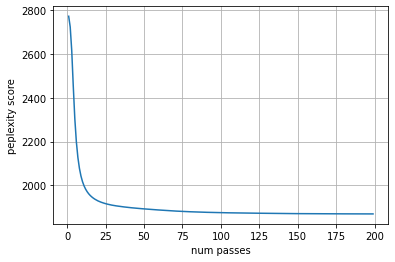

In [388]:
plt.plot(list(range(1, num_passes)), model.score_tracker['perplexity_score'].value[1:])
plt.grid()
plt.xlabel('num passes')
plt.ylabel('peplexity score')
plt.show()

#### Интерпретация результатов

Основная особенность тематических моделей — интерпретируемость получаемых матриц $\Phi$ и $\Theta$. С помощью $\Phi$ для каждой темы можно узнать топ-слова, а с помощью $\Theta$ для каждой темы можно узнать топ-документы. 
Для того, чтобы получить матрицу $\Theta$, используйте метод .transform.

Для каждой темы выведите топ её слов ($\geq 20$) и топ заголовкой её документов ($\geq 5$). Попробуйте интерпертировать полученные темы, действительно ли темы получаются осмысленными?

In [389]:
file_name_to_title = {}
with open('ted_collection/titles_file.json') as f:
    for line in f:
        file_name_to_title.update(json.loads(line))

In [390]:
import pandas as pd

phi = model.get_phi()
lst = []
for topic in phi:
    d = dict(phi[topic])
    lst.append(sorted(d, reverse=True, key = lambda x: d[x]))
top_words = pd.DataFrame(lst, index=[f'topic_{i}' for i in range(30)])

In [391]:
top_words.iloc[:, : 20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
topic_0,water,energy,climate,year,change,need,oil,carbon,percent,world,air,fuel,global,gas,problem,system,one,much,use,u
topic_1,patient,health,disease,cancer,doctor,drug,care,medical,one,hospital,treatment,year,medicine,heart,need,percent,blood,problem,well,get
topic_2,company,money,dollar,business,market,year,percent,make,work,cost,one,product,would,need,get,buy,job,pay,value,new
topic_3,data,technology,computer,information,internet,like,use,phone,world,network,one,new,system,digital,using,time,u,could,device,see
topic_4,woman,men,girl,sex,like,male,female,one,man,gender,want,laughter,boy,would,say,right,young,applause,talk,u
topic_5,word,language,world,one,god,say,think,u,human,way,book,idea,religion,people,culture,said,would,thing,believe,story
topic_6,country,world,africa,year,china,percent,people,india,one,state,african,see,today,growth,global,two,million,billion,population,economic
topic_7,music,sound,applause,play,like,song,hear,one,thank,voice,dance,come,time,way,singing,piece,la,poem,would,end
topic_8,design,building,material,like,make,one,build,designer,project,architecture,made,space,new,could,built,product,use,plastic,also,would
topic_9,robot,one,go,time,ca,year,like,fly,get,mar,going,foot,two,could,first,see,space,take,mile,earth


In [392]:
theta = model.transform(batch_vectorizer=batch_vectorizer_mono).T
lst = []
for topic in theta:
    d = dict(theta[topic])
    lst.append(sorted(d, reverse=True, key = lambda x: d[x]))
top_docs = pd.DataFrame(lst, index=[f'topic_{i}' for i in range(30)])

In [393]:
top_docs.iloc[:, : 5].applymap(lambda x: file_name_to_title[x])

,0,1,2,3,4
topic_0,James Hansen: Why I must speak out about clima...,Johan Rockström: Let the environment guide our...,Alice Bows-Larkin: Climate change is happening...,Al Gore: What comes after An Inconvenient Truth?,Jennifer Wilcox: A new way to remove CO2 from ...
topic_1,Matthias Müllenbeck: What if we paid doctors t...,Laura Indolfi: Good news in the fight against ...,Romina Libster: The power of herd immunity,Joshua Smith: New nanotech to detect cancer early,Boghuma Kabisen Titanji: Ethical riddles in HI...
topic_2,Ashwini Anburajan: How cryptocurrency can help...,William Black: How to rob a bank (from the ins...,Dan Pallotta: The way we think about charity i...,Wendy Woods: The business benefits of doing good,Niti Bhan: The hidden opportunities of the inf...
topic_3,"Ryan Merkley: Online video -- annotated, remix...",Vikram Sharma: How quantum physics can make en...,Christopher Soghoian: How to avoid surveillanc...,Avi Rubin: All your devices can be hacked,Ian Ritchie: The day I turned down Tim Berners...
topic_4,Sofia Jawed-Wessel: The lies we tell pregnant ...,"Stew: ""Black Men Ski""",Jackson Katz: Violence against women -- it's a...,Chimamanda Ngozi Adichie: We should all be fem...,Roxane Gay: Confessions of a bad feminist
topic_5,"Feisal Abdul Rauf: Lose your ego, find your co...",David Brooks: Should you live for your résumé ...,Karina Galperin: Should we simplify spelling?,Kwame Anthony Appiah: Is religion good or bad?...,Lesley Hazleton: On reading the Koran
topic_6,Hans Rosling: Let my dataset change your mindset,Hans Rosling: Asia's rise -- how and when,Yasheng Huang: Does democracy stifle economic ...,Thomas Piketty: New thoughts on capital in the...,Charles Robertson: Africa's next boom
topic_7,Herbie Hancock: An all-star set,Kaki King: A musical escape into a world of li...,"The Soul Rebels: ""Rebelosis"" / ""Rebel Rock"" / ...",Sleepy Man Banjo Boys: Teen wonders play blueg...,Danielle de Niese: A flirtatious aria
topic_8,"Skylar Tibbits: The emergence of ""4D printing""",Joseph DeSimone: What if 3D printing was 100x ...,Greg Lynn: Organic algorithms in architecture,Amit Kalra: 3 creative ways to fix fashion's w...,Lisa Harouni: A primer on 3D printing
topic_9,Yves Rossy: Fly with the Jetman,Markus Fischer: A robot that flies like a bird,Steve Truglia: A leap from the edge of space,Saul Griffith: High-altitude wind energy from ...,Joel Levine: Why we need to go back to Mars


Как можно увидеть, темы получились довольно осмысленными:   
    
    1) Проблема изменения климата
    2) Медицина, онкологические заболевания
    3) Финансы, бизнес
    4) Хакеры, шифры, шпионаж
    5) Феминизм
    и т. д.

In [406]:
# Ячейка для вывода полных названий, а то в таблицу не помещаются
for i in range(5):
    print(file_name_to_title[top_docs.T['topic_4'][i]])

Sofia Jawed-Wessel: The lies we tell pregnant women
Stew: "Black Men Ski"
Jackson Katz: Violence against women -- it's a men's issue
Chimamanda Ngozi Adichie: We should all be feminists
Roxane Gay: Confessions of a bad feminist


## Мультиязычная тематическая модель (5 баллов)

В этом пункте задания вам будет необходимо обучить мультиязычную тематическую модель.

В данном пункте вы будете реализовывать модель ML-TD (MultiLingual Parallel).

* каждый язык — отдельная модальность
* $\theta_{td}$ — общая для всех параллельных документов

Таким образом на обучении все параллельные документы записываются в одну строку в vowpal wabbit файле.

Оценивать качество модели мы будем на задаче поиска перевода текста. Вам будет необходимо оценить качество трёх переводов: с русского на английский, с испанского на английский и с русского на испанский.

Поиск документов будет устроен следующим образом. Будем для документа d на языке A считать близости со всеми документами на языке B и ранжировать документы языка B по этой близости. Для каждого документа посчитаем позицию истинного перевода документа в выдаче. Итоговая метрика — медиана или среднее таких позиций по всем документам.

Выделим множества документов, для которых не было известно информации об их переводе:

In [186]:
ru_es_parallel_docs_test = load_parallel_documents_info('ted_collection/ru_es_match_test.txt', verbose=False)
ru_en_parallel_docs_test = load_parallel_documents_info('ted_collection/ru_en_match_test.txt', verbose=False)
es_en_parallel_docs_test = load_parallel_documents_info('ted_collection/es_en_match_test.txt', verbose=False)

Проведите подготовительный этап (создание батчей и словарей) для мультиязычной коллекции DATA_PATH_PARALLEL.

In [195]:
# папка с батчами
BATCHES_PATH_PARALLEL = 'ted_collection/batches_parallel'

In [196]:
# если BATCHES_PATH_PARALLEL пуста, батчи будут созданы из файла в DATA_PATH_PARALLEL
# иначе использовать BATCHES_PATH_PARALLEL
if len(glob.glob(os.path.join(BATCHES_PATH_PARALLEL + '/*.batch'))) < 1:
    batch_vectorizer_parallel = artm.BatchVectorizer(data_path=DATA_PATH_PARALLEL, 
                                                 data_format='vowpal_wabbit',
                                                 target_folder=BATCHES_PATH_PARALLEL)
else:
    batch_vectorizer_parallel = artm.BatchVectorizer(data_path=BATCHES_PATH_PARALLEL,
                                                 data_format='batches')

In [197]:
dict_parallel = artm.Dictionary()
dict_parallel.gather(data_path=BATCHES_PATH_PARALLEL)

In [198]:
MIN_DF = 5

dict_parallel.filter(min_df=MIN_DF)

artm.Dictionary(name=4aec8b1f-bf7f-4f87-99ad-278810711301, num_entries=51781)

Обучите мультиязычную модель и проинтерпертируйте полученные темы. Если вы всё сделали правильно, то топ-слова различных языков для одной темы должны получиться достаточно похожими.

In [371]:
model_parallel = artm.ARTM(num_topics=30,
                  num_processors=7,
                  theta_columns_naming='title',
                  show_progress_bars=True,
                  class_ids={'@english':10, '@russian':5, '@spanish':1})

model_parallel.initialize(dict_parallel)

In [372]:
model_parallel.scores.add(artm.PerplexityScore(name='perplexity_score', 
                                      dictionary=dict_parallel, 
                                      class_ids=['@english', 'russian', 'spanish']))

model_parallel.scores.add(artm.SparsityPhiScore(name='en_sparsity_phi_score',
                                       class_id='@english'))
model_parallel.scores.add(artm.SparsityPhiScore(name='ru_sparsity_phi_score',
                                       class_id='@russian'))
model_parallel.scores.add(artm.SparsityPhiScore(name='es_sparsity_phi_score',
                                       class_id='@spanish'))

model_parallel.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))

model_parallel.scores.add(artm.TopTokensScore(name='en_top_tokens_score',
                                     class_id='@english'))
model_parallel.scores.add(artm.TopTokensScore(name='ru_top_tokens_score',
                                     class_id='@russian'))
model_parallel.scores.add(artm.TopTokensScore(name='es_top_tokens_score',
                                     class_id='@spanish'))

In [373]:
num_passes = 300
model_parallel.fit_offline(batch_vectorizer=batch_vectorizer_parallel, num_collection_passes=num_passes)

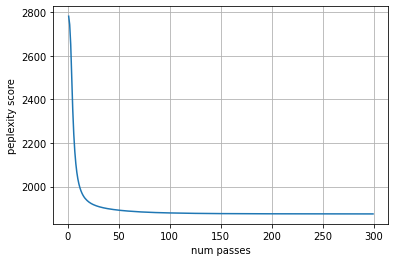

In [376]:
plt.plot(list(range(1, num_passes)), model_parallel.score_tracker['perplexity_score'].value[1:])
plt.grid()
plt.xlabel('num passes')
plt.ylabel('peplexity score')
plt.show()

In [407]:
model_parallel.score_tracker['ru_top_tokens_score'].last_tokens

{'topic_0': ['это',
  'энергия',
  'вода',
  'наш',
  'который',
  'мочь',
  'год',
  'проблема',
  'весь',
  'большой'],
 'topic_1': ['это',
  'жизнь',
  'человек',
  'свой',
  'наш',
  'мочь',
  'который',
  'друг',
  'чувствовать',
  'чувство'],
 'topic_2': ['это',
  'клетка',
  'рак',
  'который',
  'мочь',
  'лекарство',
  'пациент',
  'болезнь',
  'исследование',
  'лечение'],
 'topic_3': ['это',
  'технология',
  'мочь',
  'компьютер',
  'дать',
  'который',
  'машина',
  'использовать',
  'информация',
  'устройство'],
 'topic_4': ['женщина',
  'это',
  'мужчина',
  'свой',
  'который',
  'девочка',
  'её',
  'весь',
  'говорить',
  'наш'],
 'topic_5': ['ребёнок',
  'школа',
  'это',
  'который',
  'образование',
  'учитель',
  'студент',
  'мочь',
  'наш',
  'учиться'],
 'topic_6': ['это',
  'страна',
  'который',
  'африка',
  'деньга',
  'год',
  'экономика',
  'рынок',
  'мир',
  'весь'],
 'topic_7': ['смех',
  'это',
  'всё',
  'аплодисменты',
  'знать',
  'мочь',
  'спаси

In [408]:
model_parallel.score_tracker['en_top_tokens_score'].last_tokens

{'topic_0': ['food',
  'energy',
  'water',
  'need',
  'climate',
  'oil',
  'plant',
  'world',
  'carbon',
  'change'],
 'topic_1': ['life',
  'feel',
  'u',
  'people',
  'love',
  'like',
  'time',
  'experience',
  'one',
  'way'],
 'topic_2': ['cancer',
  'cell',
  'disease',
  'patient',
  'drug',
  'one',
  'blood',
  'medicine',
  'actually',
  'see'],
 'topic_3': ['data',
  'technology',
  'computer',
  'car',
  'information',
  'use',
  'phone',
  'device',
  'world',
  'like'],
 'topic_4': ['woman',
  'men',
  'girl',
  'sex',
  'black',
  'like',
  'u',
  'man',
  'boy',
  'male'],
 'topic_5': ['school',
  'kid',
  'child',
  'student',
  'education',
  'teacher',
  'one',
  'learning',
  'learn',
  'parent'],
 'topic_6': ['country',
  'money',
  'africa',
  'world',
  'business',
  'company',
  'market',
  'percent',
  'economy',
  'dollar'],
 'topic_7': ['laughter',
  'like',
  'know',
  'applause',
  'one',
  'right',
  'oh',
  'say',
  'go',
  'yeah'],
 'topic_8': ['d

Видим что топ слова тем в русских и английских документах похожи друг на друга.

Протестируйте качество на трёх задачах перевода. Добейтесь хорошего качества (медиана позиции в выдаче ~ 0, среднее ~ 10). Получить положение в выдаче переводов текстов вам поможет функция get_indexes_of_relevant_documents из модуля lab4_utils. Для того, чтобы всё работало корректно (на тесте не должна быть известна информация о параллельности документов), подавайте в качестве theta результат model.transform(batch_vectorizer_mono).

Возможные способы улучшения:
* изменять веса модальностей
* изменять количество тем, количество итераций обучения
* добавлять регуляризаторы (см. бонусную часть)
* изменять метрику для поиска ближайших документов
* добавлять шаги в предобработку (выделение колокаций)

**В первую очередь** рекомендуется подобрать количество тем (в данной задаче хорошо работает небольшое число тем - несколько десятков) и веса модальностей.

За нетривиальные подходы могут быть начислены дополнительные бонусные баллы!

In [409]:
result = []
result.append(get_indexes_of_relevant_documents(model_parallel.transform(batch_vectorizer_mono), ru_es_parallel_docs_test))
result.append(get_indexes_of_relevant_documents(model_parallel.transform(batch_vectorizer_mono), ru_en_parallel_docs_test))
result.append(get_indexes_of_relevant_documents(model_parallel.transform(batch_vectorizer_mono), es_en_parallel_docs_test))

In [410]:
print('Средние значения:')
print('ru_es:', sum(result[0][0])/len(result[0][0]))
print('ru_en:', sum(result[1][0])/len(result[1][0]))
print('es_en:', sum(result[2][0])/len(result[2][0]))

Средние значения:
ru_es: 10.11625
ru_en: 9.19625
es_en: 3.56


In [411]:
print('Количество нулевых элементов:')
print('ru_es:', sum([e == 0 for e in result[0][0]]), 'из', len(result[0][0]))
print('ru_en:', sum([e == 0 for e in result[1][0]]), 'из', len(result[1][0]))
print('es_en:', sum([e == 0 for e in result[2][0]]), 'из', len(result[2][0]))

Количество нулевых элементов:
ru_es: 455 из 800
ru_en: 536 из 800
es_en: 654 из 800


Проведите анализ ошибок. На каких документах модель отработала лучше всего, на каких хуже всего? Как вы думаете почему?

В качестве вывода можно отметить, что модель лучше отработала с английскими и испанскими документами, а вот с русским языком получилось похуже. Это может быть связано с неоптимальным подбором весов модальностей, или же с тем, что английский и испанский языки похожи друг на друга больше, чем на русский язык.